In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
import bambi as bmb
import arviz as az

az.style.use("arviz-darkgrid")

In [4]:
laptop_or_server = 1
if laptop_or_server:
    # laptop folder
    folder = "../../_data/p-dengue/"
else:
    # server folder
    folder = "../../../data/lucaratzinger_data/p-dengue/"

In [5]:
a10 = read_in(folder, admin=1, max_lag=0)
a20 = read_in(folder, admin=2, max_lag=0)

In [6]:
a10.isna().sum()

admin1                               0
year                                 0
month                                0
cases                              272
ONI                                  0
t2m_mean_unweighted (0)              0
t2m_mean_pop_weighted (0)            0
t2m_min_unweighted (0)               0
t2m_min_pop_weighted (0)             0
t2m_max_unweighted (0)               0
t2m_max_pop_weighted (0)             0
rh_mean_unweighted (0)               0
rh_mean_pop_weighted (0)             0
tp_24hmean_unweighted (0)            0
tp_24hmean_pop_weighted (0)          0
tp_24hmax_unweighted (0)             0
tp_24hmax_pop_weighted (0)           0
population                           0
urbanisation_nonweighted             0
urbanisation_pop_weighted            0
surveillance_nonweighted             0
surveillance_pop_weighted            0
urban_surveillance_nonweighted       0
urban_surveillance_pop_weighted      0
density_unweighted                   0
density_pop_weighted     

---

# Intercept only model

In [9]:
model_a10 = bmb.Model(
    "cases ~ offset(log(population)) + urbanisation_nonweighted",
    family="negativebinomial",
    data=a10,
    dropna=True
)
model_a10.build()

Automatically removing 272/4104 rows from the dataset.


In [10]:
model_a10.backend.model

                   alpha ~ HalfCauchy(0, 1)
               Intercept ~ Normal(0, 2.98)
urbanisation_nonweighted ~ Normal(0, 11.9)
                      mu ~ Deterministic(f(Intercept, urbanisation_nonweighted))
                   cases ~ NegativeBinomial(alpha, f(alpha, Intercept, urbanisation_nonweighted))

In [30]:
idata_a10 = model_a10.fit(tune=1000, draws=2000, chains=4, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [31]:
idata_a10

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [32]:
pps_a10 = model_a10.predict(idata_a10, kind="response")

In [27]:
idata_a10.posterior.data_vars


Data variables:
    Intercept  (chain, draw) float64 64kB -10.11 -10.11 -10.11 ... -10.11 -10.12
    mu         (chain, draw, __obs__) float64 245MB 198.2 198.2 ... 624.7 624.7

In [35]:
az.summary(idata_a10, group='posterior')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-10.114,0.001,-10.116,-10.112,0.000,0.000,3531.0,5117.0,1.0
mu[0],198.213,0.188,197.870,198.569,0.003,0.002,3531.0,5117.0,1.0
mu[1],198.213,0.188,197.870,198.569,0.003,0.002,3531.0,5117.0,1.0
mu[2],198.213,0.188,197.870,198.569,0.003,0.002,3531.0,5117.0,1.0
mu[3],198.213,0.188,197.870,198.569,0.003,0.002,3531.0,5117.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[3827],625.691,0.593,624.609,626.815,0.010,0.006,3531.0,5117.0,1.0
mu[3828],625.691,0.593,624.609,626.815,0.010,0.006,3531.0,5117.0,1.0
mu[3829],625.691,0.593,624.609,626.815,0.010,0.006,3531.0,5117.0,1.0
mu[3830],625.691,0.593,624.609,626.815,0.010,0.006,3531.0,5117.0,1.0


KeyboardInterrupt: 

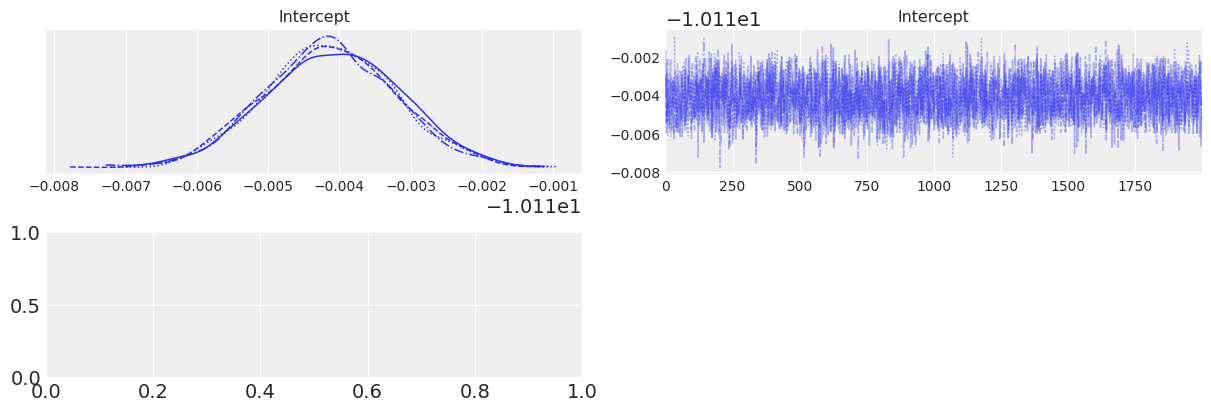

In [20]:
az.plot_trace(idata_a10)

In [ ]:
loo_a10 = az.loo(idata_a10)
loo_a10

/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/stats/stats.py:1042: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 3832 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -546795.41  26340.04
p_loo      764.48        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     3802   99.2%
   (0.70, 1]   (bad)        16    0.4%
   (1, Inf)   (very bad)   14    0.4%

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

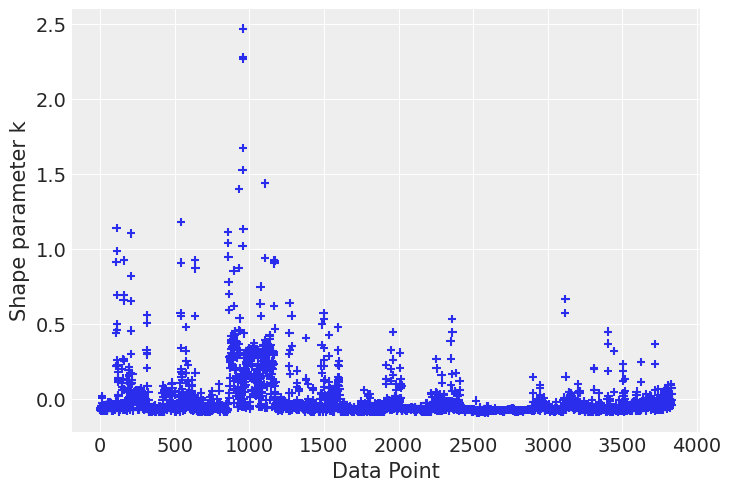

In [ ]:
az.plot_khat(loo_a10)

<Axes: xlabel='cases'>

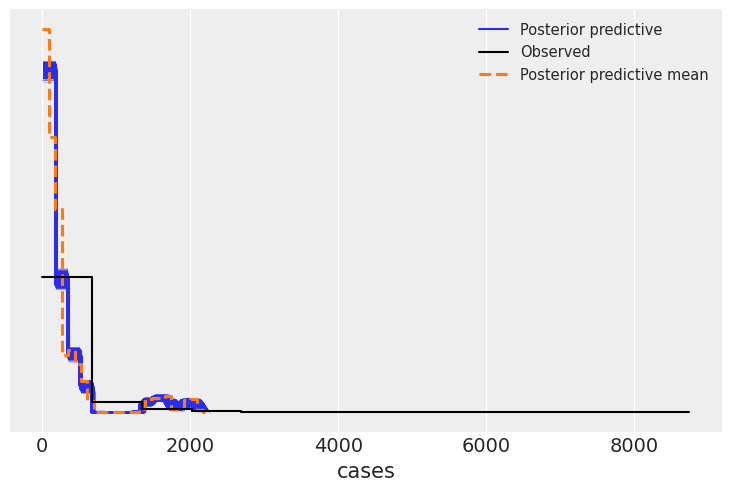

In [22]:
az.plot_ppc(idata_a10)

In [23]:
az.plot_loo_pit(idata_a10)

ValueError: y_hat cannot be None if y is not a str